In [225]:
import nltk
import codecs
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
from scipy.cluster import hierarchy as sch
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models
from bertopic import BERTopic
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.model_selection import RandomizedSearchCV
from nltk.corpus import stopwords
import string
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import nltk.tokenize
from tqdm import tqdm_notebook as tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
import scipy.stats as stats
from bokeh.io import output_notebook
from textblob import TextBlob
from sklearn.metrics import mean_squared_error, roc_curve, auc
output_notebook()

Loading BokehJS ...

In [ ]:
# In order to visualize itneractive plotly figures, the notebook needs to run again
# Interactive figures do not remain after a kernel has shutted

In [2]:
raw = pd.read_json('reviews.json')

df = raw.copy(deep=True)
df.head()

,datetime,review,rating,agent_response,review_id
0,2022-09-02T12:00:00,"The online banking system is fantastic, very u...",5,None,2.125057e+38
1,2022-09-04T17:30:00,I had an issue with my credit card and the cus...,2,None,1.053597e+38
2,2022-10-06T10:45:00,I recently took out a car loan and the interes...,4,None,8.201099e+37
3,2022-10-10T15:00:00,The ATM machines always seem to have plenty of...,5,None,6.915430e+37
4,2022-11-05T08:00:00,The customer service team is always so friendl...,5,None,1.818915e+38


In [3]:
df.describe()

,rating,review_id
count,389.000000,3.890000e+02
mean,3.041131,1.663484e+38
std,1.591976,9.812802e+37
min,1.000000,5.493148e+35
25%,2.000000,8.887534e+37
50%,3.000000,1.587314e+38
75%,5.000000,2.537503e+38
max,5.000000,3.401056e+38


In [4]:
# Keep only date part from datetime object and then convert to date type
df['datetime'] = df['datetime'].str.split('T').str[0]
df['datetime'] = pd.to_datetime(df['datetime'])

In [5]:
# Let's check for dublicate review ids in the dataset first
# It seems there are no dublicates
df[df.duplicated('review_id', keep=False) == True].sort_values('review_id')

,datetime,review,rating,agent_response,review_id


In [6]:
# Check if there are reviews with no text
df.review.isna().any()

False

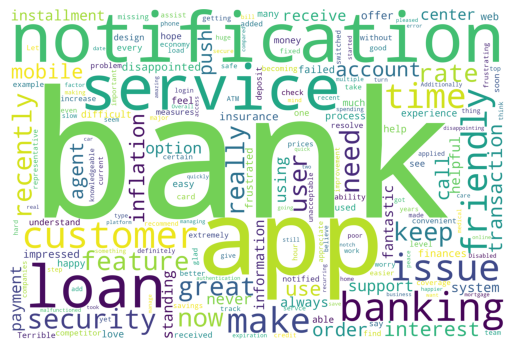

In [7]:
#Creating the text variable
text = " ".join(cat for cat in df.review)

# Generate word cloud
word_cloud = WordCloud(
    width=3000,
    height=2000,
    random_state=1,
    background_color="white",
    collocations=False,
    stopwords=STOPWORDS,
    ).generate(text)

# Display the generated Word Cloud
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

In [8]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

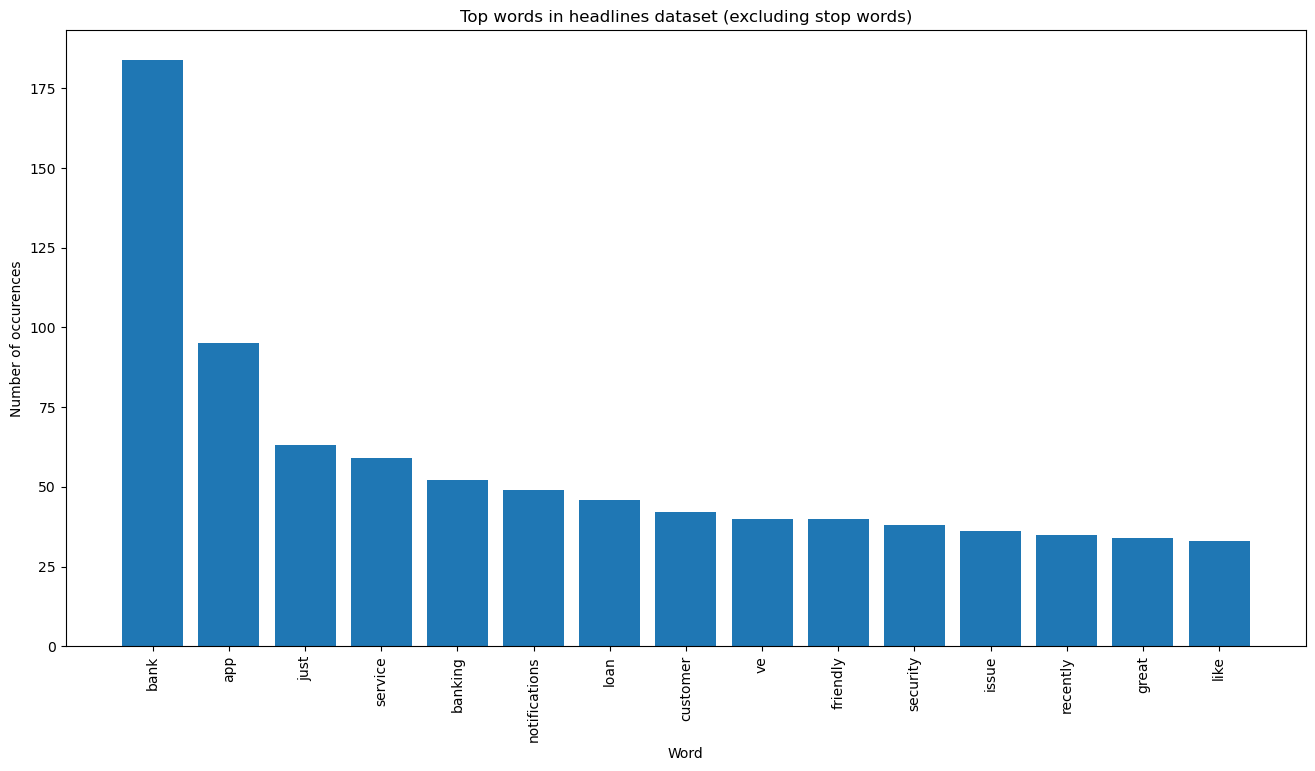

In [9]:
reindexed_data = df['review']
reindexed_data.index = df['datetime']

count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset (excluding stop words)')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

In [10]:
tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(reindexed_data.shape[0])]

In [11]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Total number of words:  8822
Mean number of words per headline:  22.67866323907455


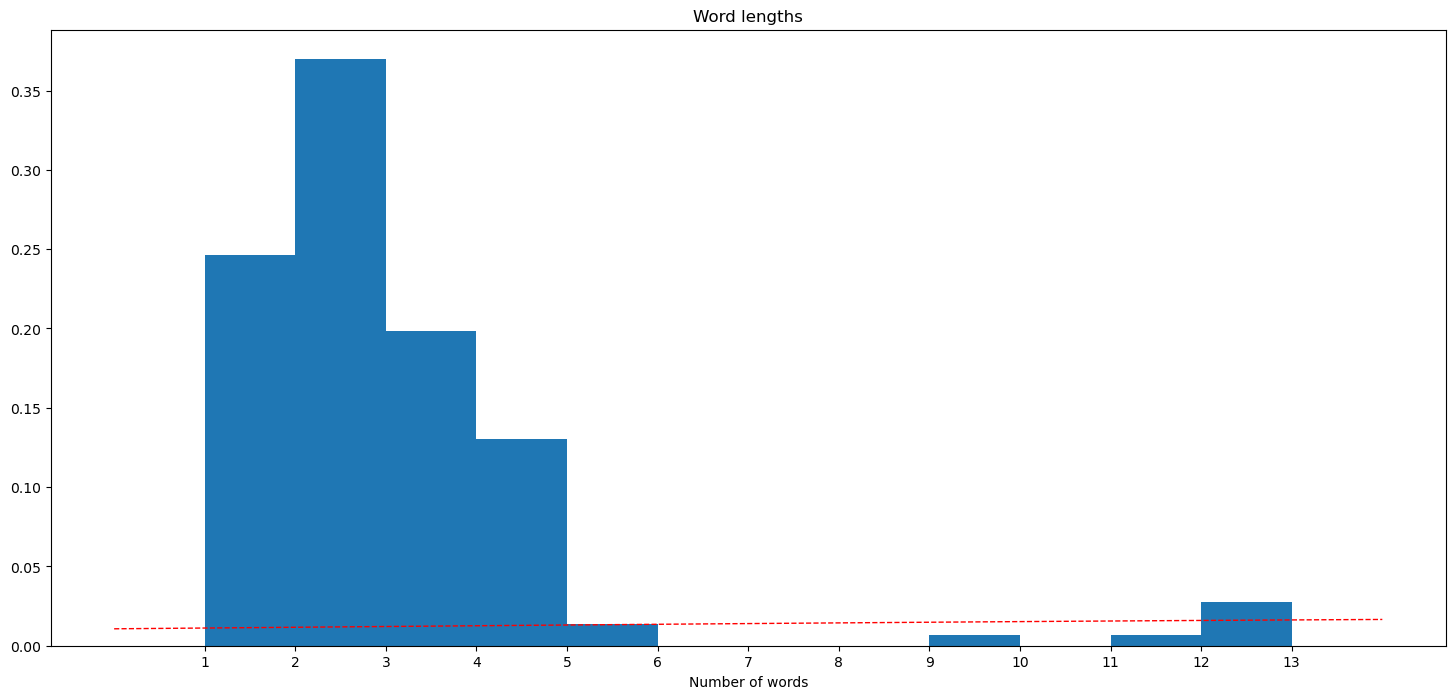

In [175]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,14), density=True)
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1)
ax.set_title('Word lengths')
ax.set_xticks(range(1,14))
ax.set_xlabel('Number of words')
plt.show()

Text(0.5, 0, 'Type of Word')

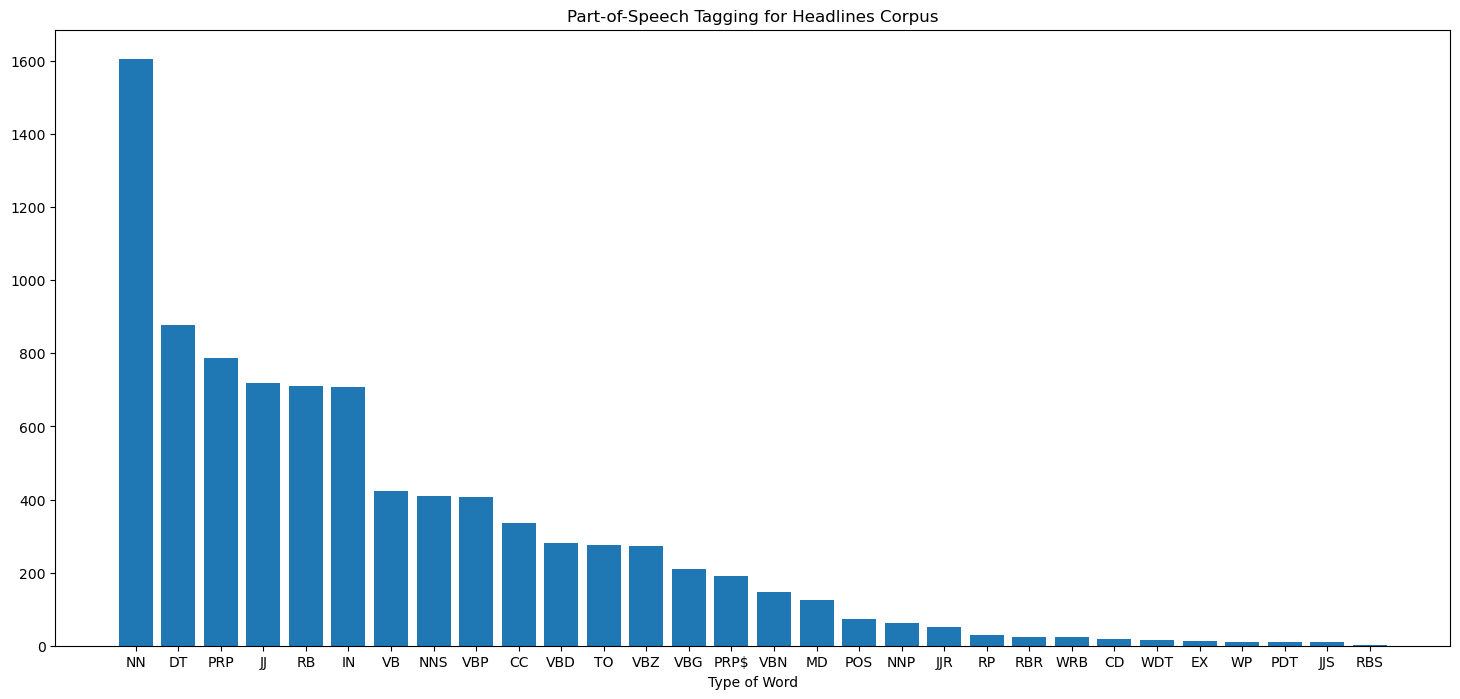

In [13]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts)
ax.set_xticks(range(len(pos_counts)))
ax.set_xticklabels(pos_sorted_types)
ax.set_title('Part-of-Speech Tagging for Headlines Corpus')
ax.set_xlabel('Type of Word')

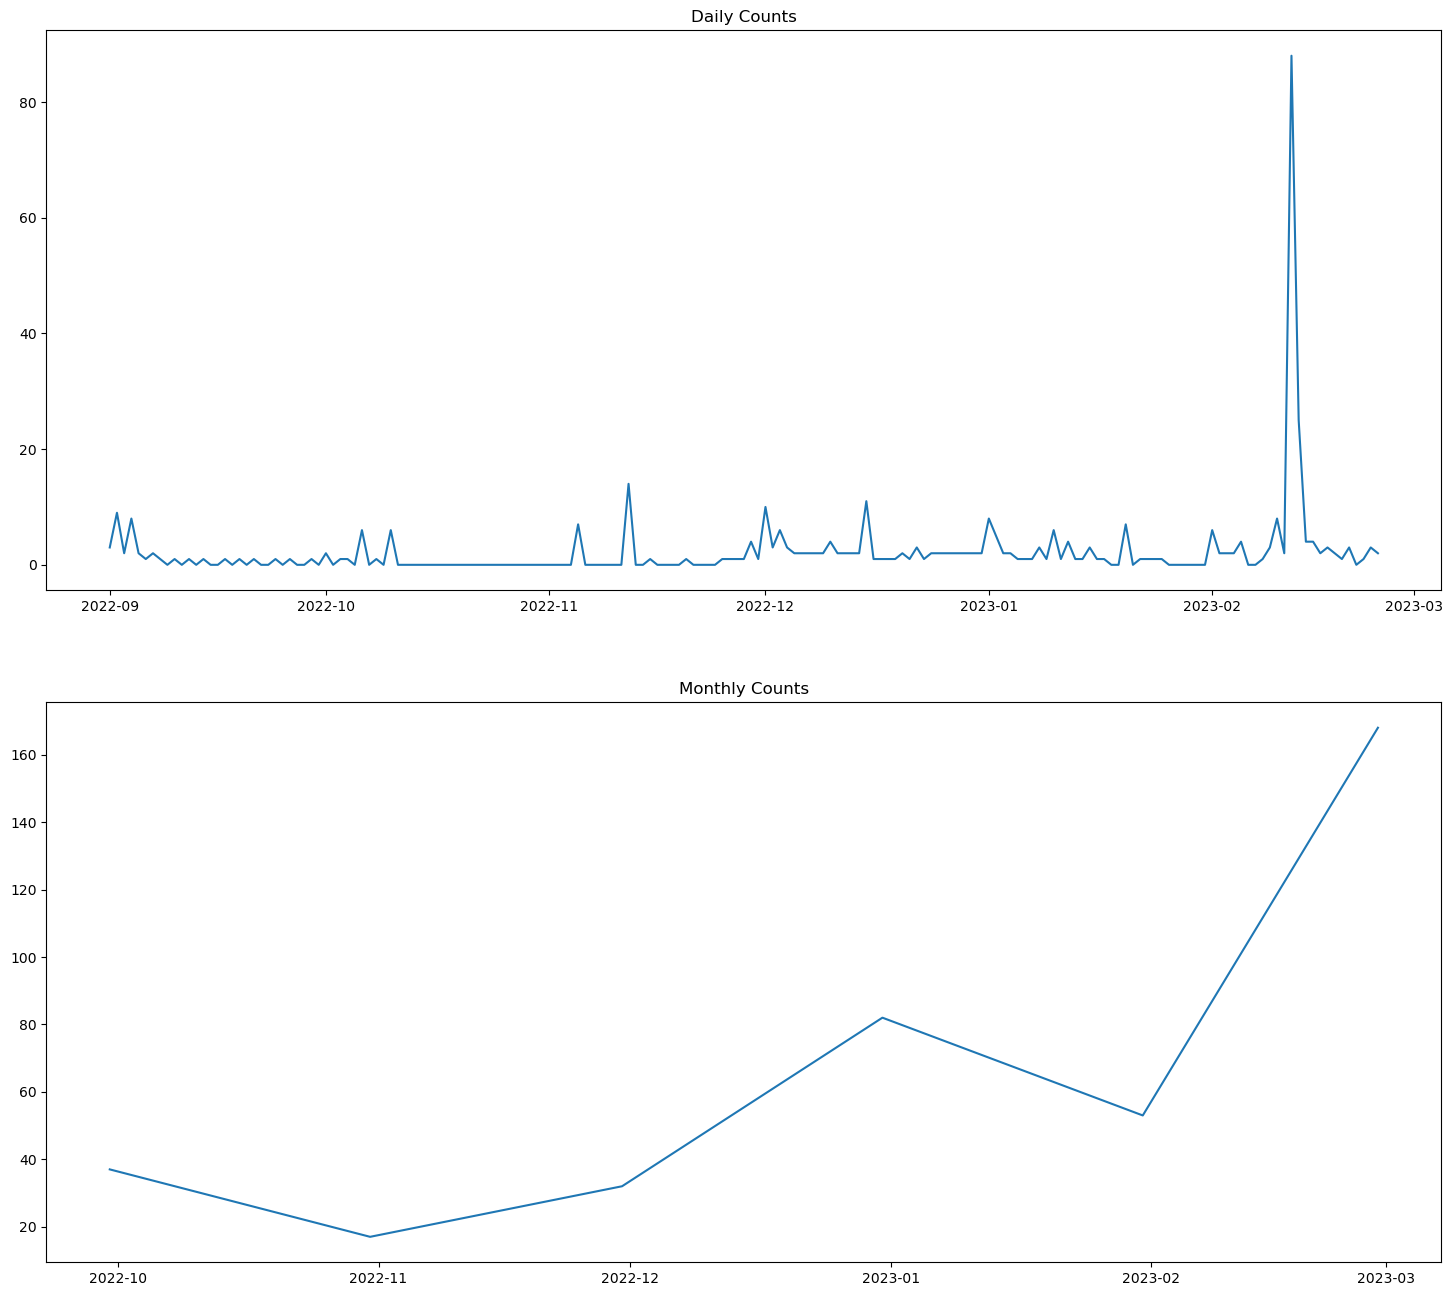

In [14]:
monthly_counts = reindexed_data.resample('M').count()
daily_counts = reindexed_data.resample('D').count()

fig, ax = plt.subplots(2, figsize=(18,16))
ax[0].plot(daily_counts)
ax[0].set_title('Daily Counts')
ax[1].plot(monthly_counts)
ax[1].set_title('Monthly Counts')
plt.show()

# Topic Modeling

In [44]:
# Twenty one topics identified initially.
# Merging similar topics in one resulted in 8 distinct and clear groups of feedbacks and their associated, most important words mentioned.
# Derived topics can have a positive or a more negative tone.


docs = df.review.to_list()

# Removal of stopwords, TF-IDF calculaction & topic generation via document embeddings
stop_words = stopwords.words('english')
vectorizer_model = CountVectorizer(stop_words=stop_words)
topic_model = BERTopic(vectorizer_model=vectorizer_model, min_topic_size=5, 
                       nr_topics='auto', verbose=True)

topics, probs = topic_model.fit_transform(docs)

# Hierarchical topics
linkage_function = lambda x: sch.linkage(x, 'single', optimal_ordering=True)
hierarchical_topics = topic_model.hierarchical_topics(docs, linkage_function=linkage_function)
topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)

Batches:   0%|          | 0/12 [00:00<?, ?it/s]

2023-02-20 19:26:17,861 - BERTopic - Transformed documents to Embeddings
2023-02-20 19:26:21,605 - BERTopic - Reduced dimensionality
2023-02-20 19:26:21,654 - BERTopic - Clustered reduced embeddings
2023-02-20 19:26:53,596 - BERTopic - Reduced number of topics from 22 to 22
100%|█████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 143.97it/s]


In [47]:
freq = topic_model.get_topic_info()
freq.head(20)

,Topic,Count,Name
0,-1,13,-1_wont_load_updated_cant
1,0,43,0_app_apps_use_would
2,1,37,1_inflation_rates_interest_increase
3,2,28,2_security_measures_worry_information
4,3,26,3_installment_standing_order_failed
5,4,23,4_notifications_push_notification_keep
6,5,20,5_center_call_agent_support
7,6,19,6_include_everyone__
8,7,18,7_service_customer_years_always
9,8,17,8_greatly_truly_totally_superb


In [48]:
topic_model.visualize_barchart(n_words=10, top_n_topics=30, height = 300, width = 250)

In [24]:
topic_model.visualize_heatmap()

In [49]:
topics_to_merge = [[0, 2, 3, 11, 12],
                   [1, 13, 17],
                   [4, 19],
                   [5, 7, 8, 15],
                   [6, 10],
                   [9, 18],
                   [14, 16]]
                   
topic_model.merge_topics(docs, topics_to_merge)

In [51]:
topic_model.set_topic_labels({0: "App & Web", 1: "Positive CSX", 2: "Loan/Other Products", 
                              3: "Accessibility", 4: "Mobile Notifications",
                              5: "Negative CSX", 6: "Insurance",
                              7: "ATMs"})

In [52]:
topic_model.visualize_barchart(n_words=10, top_n_topics=30, height = 300, width = 250, custom_labels=True)

In [53]:
freq2 = topic_model.get_topic_info()
freq2.head(20)

,Topic,Count,Name,CustomName
0,-1,13,-1_wont_load_updated_cant,-1_wont_load_updated_cant
1,0,123,0_app_banks_security_features,App & Web
2,1,66,1_center_service_call_agent,Positive CSX
3,2,59,2_inflation_interest_rates_loan,Loan/Other Products
4,3,33,3_disabled_accessibility_users_needed,Accessibility
5,4,32,4_notifications_push_notification_keep,Mobile Notifications
6,5,23,5_service_terrible_resolve_customer,Negative CSX
7,6,23,6_insurance_im_notified_coverage,Insurance
8,7,6,7_atm_withdraw_machines_seem,ATMs


In [230]:
topic_model.visualize_topics()

In [56]:
# Create column with topics in original dataset and drop rows with topics identified as outliers
df['topic'] = topics
df = df[df.topic != -1]

df['topic'] = df['topic'].replace([0, 2, 3, 11, 12], 'App & Web')
df['topic'] = df['topic'].replace([1, 13, 17], 'Loan/Other Products')
df['topic'] = df['topic'].replace([4, 19], 'Notifications')
df['topic'] = df['topic'].replace([5, 7, 8, 15], 'Positive CSX')
df['topic'] = df['topic'].replace([6, 10], 'Accessibility')
df['topic'] = df['topic'].replace([9, 18], 'Negative CSX')
df['topic'] = df['topic'].replace([14, 16], 'Insurance')
df['topic'] = df['topic'].replace([20], 'ATMs')

df.head(5)

,datetime,review,rating,agent_response,review_id,topic
0,2022-09-02,"The online banking system is fantastic, very u...",5,None,2.125057e+38,App & Web
1,2022-09-04,I had an issue with my credit card and the cus...,2,None,1.053597e+38,Negative CSX
2,2022-10-06,I recently took out a car loan and the interes...,4,None,8.201099e+37,Loan/Other Products
3,2022-10-10,The ATM machines always seem to have plenty of...,5,None,6.915430e+37,ATMs
4,2022-11-05,The customer service team is always so friendl...,5,None,1.818915e+38,Positive CSX


In [57]:
df_copy = df.copy(deep=True)

# Sentiment Analysis

<Axes: xlabel='topic', ylabel='count'>

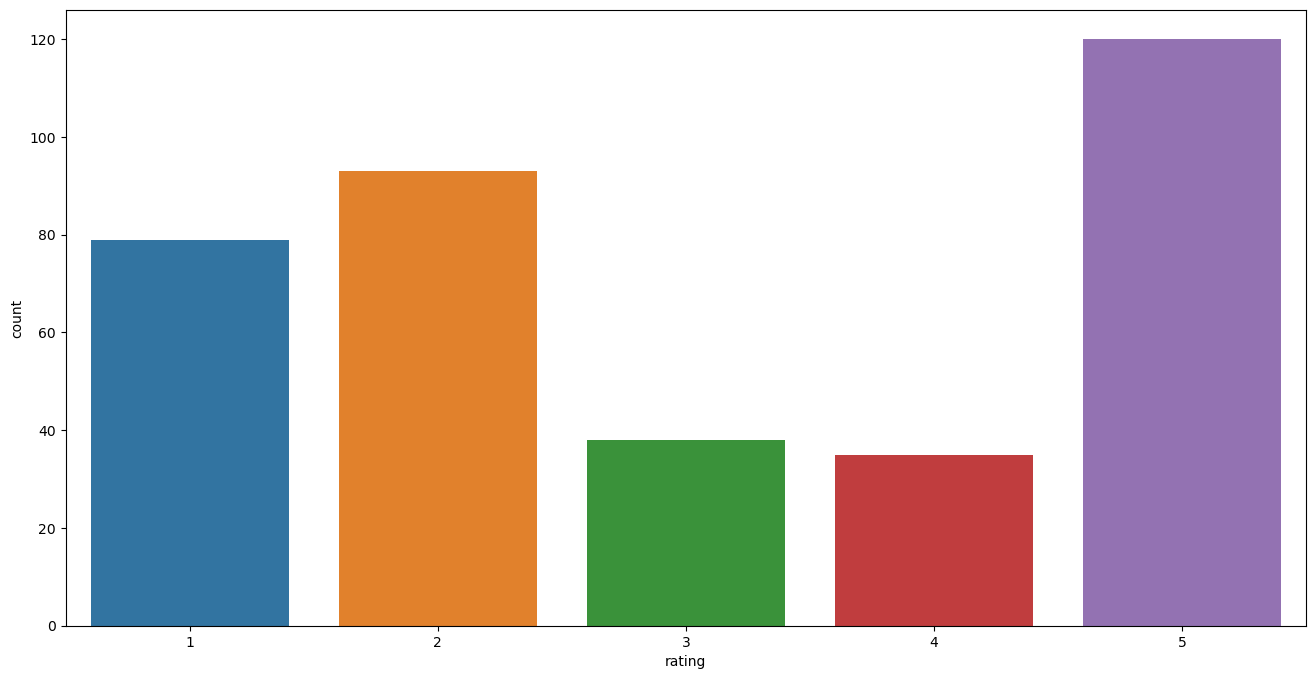

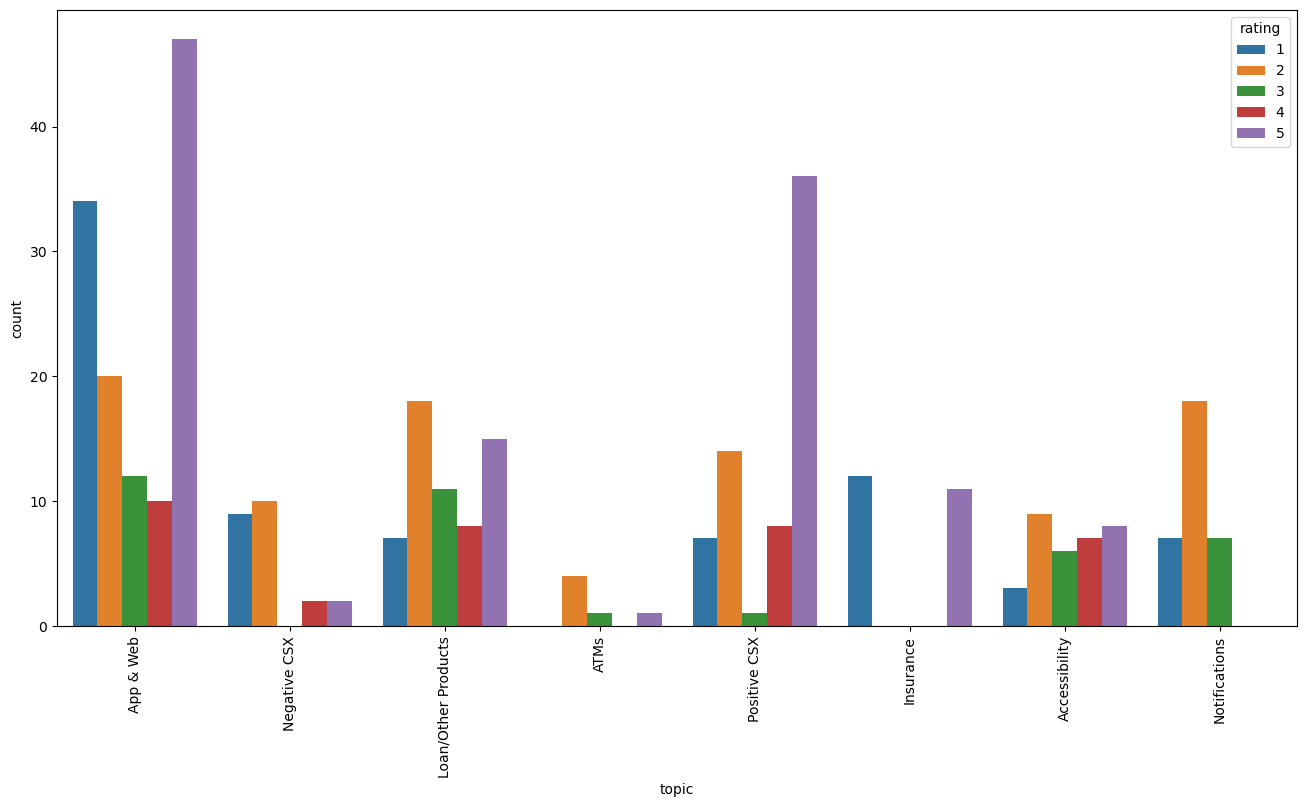

In [199]:
# Ratings provided, in many occasions confirm the topics created. Especially for “Negative CSX” or “Positive CSX” we see that majority of feedbacks have an either very low or very high rating respectively.
# Comments about insurance provided by the bank are either very low or very high.
# Mixed feelings when it comes to the rest of topics.


fig, ax = plt.subplots(figsize=(16,8))
sns.countplot(data=df, x='rating')

fig, ax = plt.subplots(figsize=(16,8))
ax.set_xticklabels(words, rotation='vertical')
sns.countplot(data=df, x='topic', hue='rating')

In [200]:
# Maximum rated feedbacks accumulate for roughly 31% of total but low rated exceed that by far.
# Ratings have been grouped in two distinct categories each one representing a sentiment: Negative & Positive

# In positive sentiments we come across frequent references to the bank app, customer service and adjectives such as fantastic, friendly, easy and great.
# In contrast negatively characterized feedbacks refer massively to annoying notifications, installments of loans and transactions.



# Helper wordcloud function
def plot_wordcloud(review):
    
    #Creating the text variable
    text = " ".join(cat for cat in review)

    # Generate word cloud
    word_cloud = WordCloud(
        width=3000,
        height=2000,
        random_state=1,
        background_color="white",
        collocations=False,
        stopwords=STOPWORDS,
        ).generate(text)

    # Display the generated Word Cloud
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()
    
    return

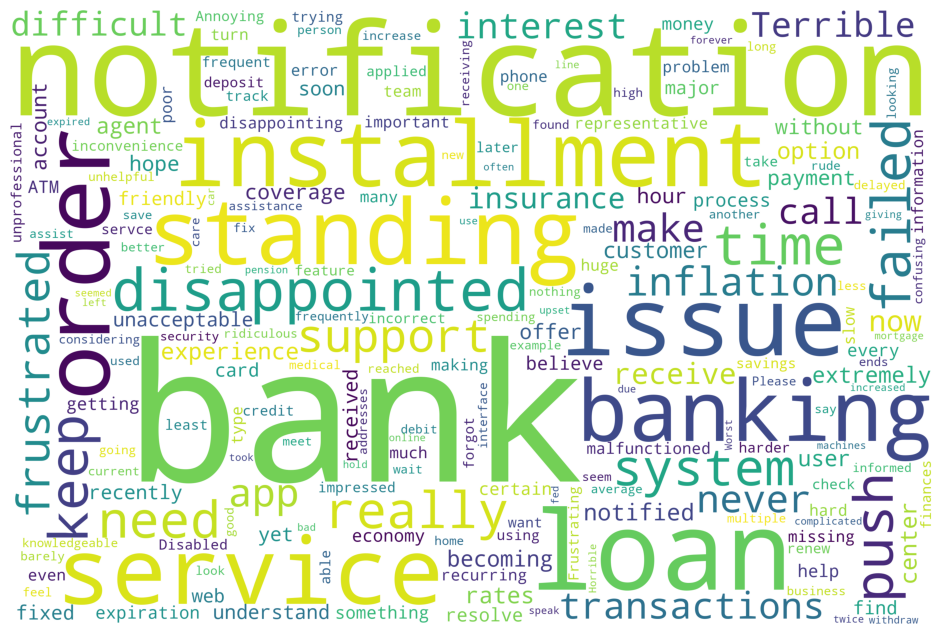

In [201]:
# Plotting low ratings brings up words such as "dissapointed", "issue", "failed", "frustrated"
plot_wordcloud(df.review.loc[df['rating'].isin([1,2])])

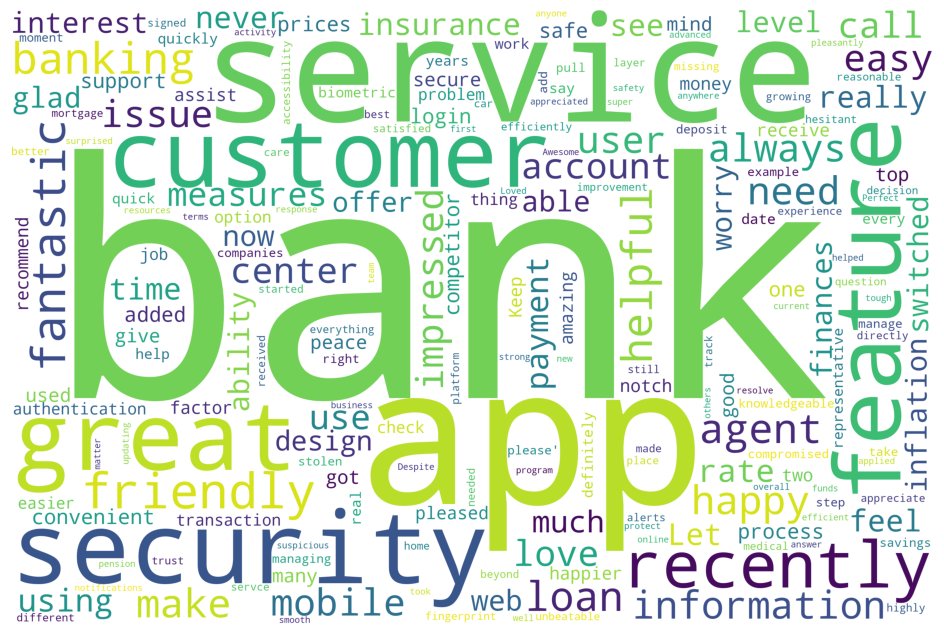

In [202]:
# Plotting high ratings brings up words such as "friendly", "fantastic", "helpful", "happy"
plot_wordcloud(df.review.loc[df['rating'].isin([4,5])])

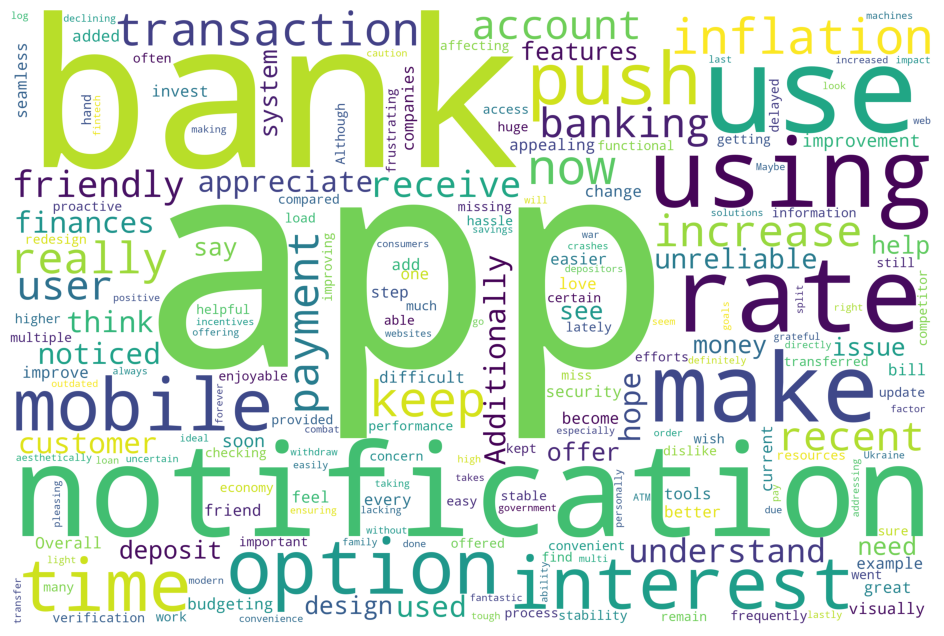

In [203]:
# Plotting middle rating brings up words such as "friendly", "appreciate" hence these will be classified as positive sentiment
plot_wordcloud(df.review.loc[df['rating'].isin([3])])

In [204]:
# Negative sentiments are labeled as 1 whilst positive as 0
df['sentiment'] = np.where(df.rating.isin([1,2]), 1, 0)
df.head()

,datetime,review,rating,agent_response,review_id,topic,sentiment
0,2022-09-02,"The online banking system is fantastic, very u...",5,None,2.125057e+38,App & Web,0
1,2022-09-04,I had an issue with my credit card and the cus...,2,None,1.053597e+38,Negative CSX,1
2,2022-10-06,I recently took out a car loan and the interes...,4,None,8.201099e+37,Loan/Other Products,0
3,2022-10-10,The ATM machines always seem to have plenty of...,5,None,6.915430e+37,ATMs,0
4,2022-11-05,The customer service team is always so friendl...,5,None,1.818915e+38,Positive CSX,0


In [207]:
punc = string.punctuation
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

#make a copy of the dataframe
data = df.copy(deep=True)

#define a function which handles the text preprocessing 
def preparation_text_data(data):
    """
    This pipeline prepares the text data, conducting the following steps:
    1) Tokenization
    2) Lemmatization
    4) Removal of stopwords
    5) Removal of punctuation
    
    """
    # initialize spacy object
    nlp = spacy.load('en_core_web_lg')
    # select raw text
    raw_text = data.review.values.tolist()
    # tokenize
    tokenized_text = [[nlp(i.lower().strip())] for i in tqdm(raw_text)]
    #define the punctuations and stop words
    punc = string.punctuation 
    stop_words = set(stopwords.words('english'))
    #lemmatize, remove stopwords and punctuation
    corpus = []
    for doc in tqdm(tokenized_text):
        corpus.append([word.lemma_ for word in doc[0] if (word.lemma_ not in stop_words and word.lemma_ not in punc)])
    # add prepared data to df
    data["text"] = corpus
    return data

#apply the data preprocessing function
data =  preparation_text_data(data)
data.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Giorgos\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\Giorgos\AppData\Local\Temp\ipykernel_11208\1881123285.py:23: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/365 [00:00<?, ?it/s]

C:\Users\Giorgos\AppData\Local\Temp\ipykernel_11208\1881123285.py:29: TqdmDeprecationWarning:

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



  0%|          | 0/365 [00:00<?, ?it/s]

,datetime,review,rating,agent_response,review_id,topic,sentiment,text
0,2022-09-02,"The online banking system is fantastic, very u...",5,None,2.125057e+38,App & Web,0,"[online, banking, system, fantastic, user, fri..."
1,2022-09-04,I had an issue with my credit card and the cus...,2,None,1.053597e+38,Negative CSX,1,"[I, issue, credit, card, customer, service, te..."
2,2022-10-06,I recently took out a car loan and the interes...,4,None,8.201099e+37,Loan/Other Products,0,"[I, recently, take, car, loan, interest, rate,..."
3,2022-10-10,The ATM machines always seem to have plenty of...,5,None,6.915430e+37,ATMs,0,"[atm, machine, always, seem, plenty, cash, I, ..."
4,2022-11-05,The customer service team is always so friendl...,5,None,1.818915e+38,Positive CSX,0,"[customer, service, team, always, friendly, he..."


In [208]:
data = data.set_index('review_id')

In [209]:
X = data[['text', 'topic']]
y = data['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [210]:
def text_representation(train, test):
    
    tfidf_vect = TfidfVectorizer()
    train = train.apply(lambda text: " ".join(set(text)))
    X_train_tfidf = tfidf_vect.fit_transform(train)
    print(X_train_tfidf.shape)
    X_train_tfidf = pd.DataFrame(X_train_tfidf.toarray())
    
    tfidf_vect2 = TfidfVectorizer(vocabulary=tfidf_vect.vocabulary_)
    test = test.apply(lambda text: " ".join(set(text)))
    X_test_tfidf = tfidf_vect2.fit_transform(test)
    print(X_test_tfidf.shape)
    X_test_tfidf = pd.DataFrame(X_test_tfidf.toarray())
    
    return X_train_tfidf, X_test_tfidf

# Apply TF-IDF function
X_train_tfidf, X_test_tfidf = text_representation(X_train['text'], X_test['text'])
X_train_tfidf.index = X_train.index
X_test_tfidf.index = X_test.index

(292, 593)
(73, 593)


In [211]:
X_train_tfidf = X_train_tfidf.merge(X_train['topic'], left_index=True, right_index=True, how='inner')
X_test_tfidf = X_test_tfidf.merge(X_test['topic'], left_index=True, right_index=True, how='inner')

In [212]:
X_train_tfidf = pd.get_dummies(X_train_tfidf, columns = ['topic'])
X_test_tfidf = pd.get_dummies(X_test_tfidf, columns = ['topic'])

In [214]:
# Fit Logistic Regression model
X_train_tfidf = X_train_tfidf.rename(columns={'topic_ATMs':593,
                                                'topic_Accessibility':594,
                                                'topic_App & Web':595,
                                                'topic_Insurance':596,
                                                'topic_Loan/Other Products':597,
                                                'topic_Negative CSX':598,
                                                'topic_Notifications':599,
                                                'topic_Positive CSX':600
                                             }
                                    )


X_test_tfidf = X_test_tfidf.rename(columns={'topic_ATMs':593,
                                            'topic_Accessibility':594,
                                            'topic_App & Web':595,
                                            'topic_Insurance':596,
                                            'topic_Loan/Other Products':597,
                                            'topic_Negative CSX':598,
                                            'topic_Notifications':599,
                                            'topic_Positive CSX':600
                                           }
                                    )


clf= LogisticRegression()
clf.fit(X_train_tfidf,y_train)

y_pred_lr = clf.predict(X_test_tfidf)
y_pred_proba_lr = pd.DataFrame(clf.predict_proba(X_test_tfidf), columns=['proba_0', 'proba_1'])
y_pred_proba_lr['label'] = np.where(y_pred_proba_lr['proba_1']>=0.38, 1, 0)

print('\nOverall Classification Accuracy:', round(100*accuracy_score(y_test, y_pred_proba_lr['label']), 2), '\n\n')
print(classification_report(y_test, y_pred_proba_lr['label']))


# Overall classification accuracy of sentiments reaches 86%.
# Predicting negative sentiments seems to be the most important segment where the bank needs to focus in order to improve its services and customer experience overall.
# With respect to the former, accurate predictions of negative sentiments hits 88%. 


Overall Classification Accuracy: 86.3 


              precision    recall  f1-score   support

           0       0.83      0.83      0.83        30
           1       0.88      0.88      0.88        43

    accuracy                           0.86        73
   macro avg       0.86      0.86      0.86        73
weighted avg       0.86      0.86      0.86        73



# Next Steps

In [ ]:
# Less and relevant notifications to bank customers.
# Improvement on insurance coverage.
# Identification of negative customer service pain points.
# Communicate to customers the security measures the banks employs in order to keep their account safe – Ease their mind.